# Estimating COVID-19's $R_t$ in Real-Time with PYMC3

Fork of Kevin Systrom's notebook by Grzegorz Kossakowski & Maciek Zdanowicz that plugs the EU data instead of the US one as the input.

Model originally built by [Thomas Vladeck](https://github.com/tvladeck) in Stan, parts inspired by the work over at https://epiforecasts.io/, lots of help from [Thomas Wiecki](https://twitter.com/twiecki). Thank you to everyone who helped.

This notebook is a WIP - I'll add more context and commentary over the coming week.

In [938]:
# For some reason Theano is unhappy when I run the GP, need to disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime
from datetime import timedelta

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [939]:
COUNTRIES_INCLUDED = ['Austria', 'Italy', 'Belgium', 'Latvia', 'Bulgaria', 'Lithuania', 'Croatia', 'Luxembourg', 
                     'Cyprus', 'Malta', 'Czechia', 'Netherlands', 'Denmark', 'Poland', 'Estonia', 'Portugal', 
                     'Finland', 'Romania', 'France', 'Slovakia', 'Germany', 'Slovenia', 'Greece', 'Spain', 
                     'Hungary', 'Sweden', 'Ireland', 'Russia', 'Norway', 'Switzerland',
                    'United_Kingdom', 'Belarus']

## Load country Information
#### Load

In [940]:
url = 'https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/'
eu_countries = pd.read_csv(url,
                     usecols=['dateRep', 'countriesAndTerritories', 'cases'],
                     parse_dates=['dateRep'],dayfirst=True,
                     index_col=['countriesAndTerritories', 'dateRep']).sort_index()

In [941]:
eu_countries.index.rename(names=['country', 'date'], inplace=True)

In [942]:
# the data coming from ECDC starts at different dates for different countries
# and many countries have leading zeros for Jan and Feb. Let's set a common cutoff
# date for all European countries that simplifies further data processing
dates_considered = pd.date_range('15-02-2020', pd.Timestamp.today())

In [1019]:
targets = eu_countries.index.get_level_values('country').isin(COUNTRIES_INCLUDED)
countries = eu_countries[targets]

# Cannot really do it using groupby.transform since this intrinsically increases the length
def prepareCountry(country, data):
    dates_old = data.index.get_level_values('date')
    # Adding all the dates and zero entries in between non-zero entries (see Poland 03-05, 03-06)
    dates_new = pd.date_range(start=dates_old[0],end=dates_old[-1])
    newindex = pd.MultiIndex.from_tuples([(country,date) for date in dates_new], names=['country','date'])
    return data.reindex(newindex,fill_value=0.0)

countries = pd.concat([prepareCountry(country,data) for country, data in countries.groupby('country')])

In [1020]:
countries

cases
country        date              
Austria        2019-12-31     0.0
               2020-01-01     0.0
               2020-01-02     0.0
               2020-01-03     0.0
               2020-01-04     0.0
...                           ...
United_Kingdom 2020-05-03  4806.0
               2020-05-04  4339.0
               2020-05-05  3985.0
               2020-05-06  4406.0
               2020-05-07  6211.0

[3534 rows x 1 columns]

## Fix data issues

In [1021]:
# find and fix outliers using Hampel filter
# Impl from: https://towardsdatascience.com/outlier-detection-with-hampel-filter-85ddf523c73d

def hampel_filter_pandas(input_series, window_size, n_sigmas=3.0):

    k = 1.4826 # scale factor for Gaussian distribution
    new_series = input_series.copy()

    # helper lambda function 
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    
    rolling_median = input_series.rolling(window=2*window_size+1, center=True).median()
    rolling_mad = k * input_series.rolling(window=2*window_size+1, center=True).apply(MAD)
    # print(f'rolling_mad = {rolling_mad}, rolling_median = {rolling_median}')
    diff = np.abs(input_series - rolling_median)
    
    where = diff > (n_sigmas * rolling_mad)
    indices = np.argwhere(where.to_numpy()).flatten()
    new_series[indices] = rolling_median[indices]
    
    return new_series, indices

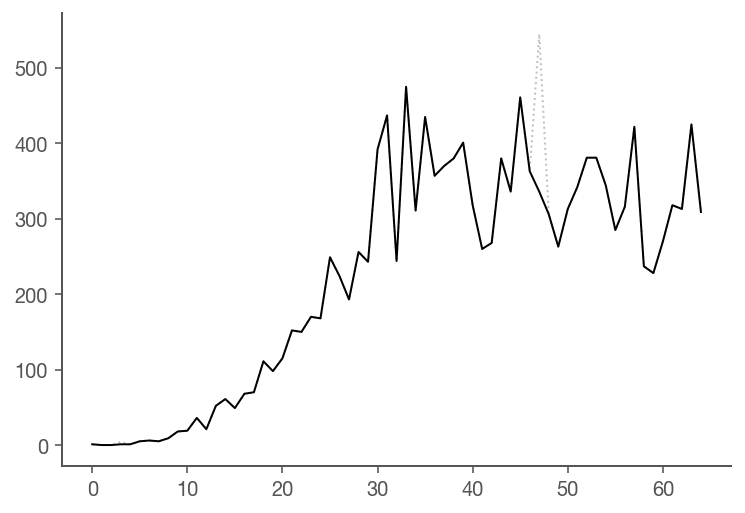

In [1022]:
country = "Poland"
rawData = countries.loc[country]['cases']

filteredData, _ = hampel_filter_pandas(rawData, 3, 2.0)
fig, ax = plt.subplots()
ax.plot(rawData.to_numpy(),alpha=0.25,c='k', linestyle=':', lw=1)
ax.plot(filteredData.to_numpy(), c='k', lw=1)

In [1023]:
def transform_cases(case_series):
    filtered, _ = hampel_filter_pandas(case_series, 3, 2.0)
    return filtered

transformedCases = countries.groupby('country').transform(transform_cases)

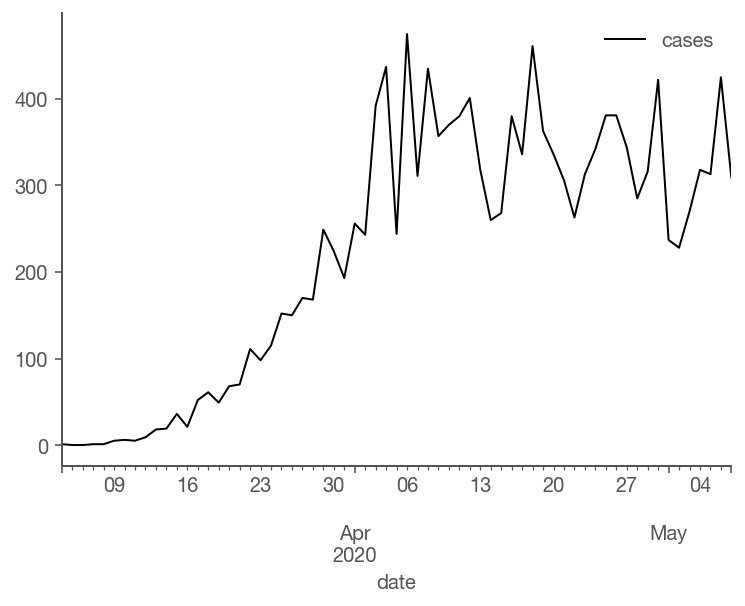

In [1024]:
transformedCases.loc[country].plot(c='k', lw=1)

In [1025]:
countries = transformedCases

#### Integrity Check

In [951]:
# Make sure that all the countries have current data
# today = datetime.combine(date.today(), datetime.min.time())
yesterday = datetime.combine(date.today() - timedelta(1), datetime.min.time())
last_updated = countries.reset_index('date').groupby('country')['date'].max()
is_current = last_updated < yesterday

try:
    assert is_current.sum() == 0
except AssertionError:
    print("Not all countries have updated")
    display(last_updated[is_current])

# Ensure all case diffs are greater than zero
for country, grp in countries.groupby('country'):
    new_cases = grp.cases.dropna()
    is_positive = new_cases.ge(0)
    
    try:
        assert is_positive.all()
    except AssertionError:
        print(f"Warning: {country} has date with negative case counts")
        display(new_cases[~is_positive])
        
# Let's make sure that countries have added cases
# idx = pd.IndexSlice
# assert not countries.loc[idx[:, '2020-04-22':'2020-04-23'], 'cases'].groupby('country').diff().dropna().eq(0).any()

## Load Patient Information
#### Download
~100mb download (be ... patient!)

In [952]:
def download_file(url, local_filename):
    """From https://stackoverflow.com/questions/16694907/"""
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
    return local_filename


URL = "https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.csv"
LINELIST_PATH = 'data/linelist.csv'

if not os.path.exists(LINELIST_PATH):
    print('Downloading file, this will take a while ~100mb')
    try:
        download_file(URL, LINELIST_PATH)
        clear_output(wait=True)
        print('Done downloading.')
    except:
        print('Something went wrong. Try again.')
else:
    print('Already downloaded CSV')

Already downloaded CSV


#### Parse & Clean Patient Info

In [953]:
# Load the patient CSV
patients = pd.read_csv(
    'data/linelist.csv',
    parse_dates=False,
    usecols=[
        'date_confirmation',
        'date_onset_symptoms'],
    low_memory=False)

patients.columns = ['Onset', 'Confirmed']

# There's an errant reversed date
patients = patients.replace('01.31.2020', '31.01.2020')

# Only keep if both values are present
patients = patients.dropna()

# Must have strings that look like individual dates
# "2020.03.09" is 10 chars long
is_ten_char = lambda x: x.str.len().eq(10)
patients = patients[is_ten_char(patients.Confirmed) & 
                    is_ten_char(patients.Onset)]

# Convert both to datetimes
patients.Confirmed = pd.to_datetime(
    patients.Confirmed, format='%d.%m.%Y')
patients.Onset = pd.to_datetime(
    patients.Onset, format='%d.%m.%Y')

# Only keep records where confirmed > onset
patients = patients[patients.Confirmed >= patients.Onset]

#### Show Relationship between Onset of Symptoms and Confirmation

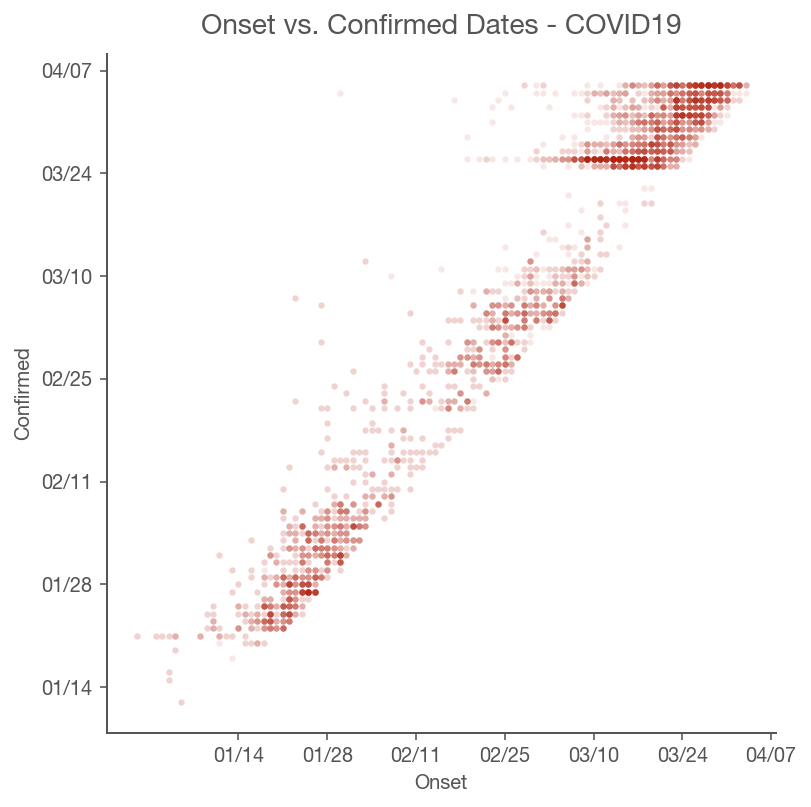

In [954]:
ax = patients.plot.scatter(
    title='Onset vs. Confirmed Dates - COVID19',
    x='Onset',
    y='Confirmed',
    alpha=.1,
    lw=0,
    s=10,
    figsize=(6,6))

formatter = mdates.DateFormatter('%m/%d')
locator = mdates.WeekdayLocator(interval=2)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(formatter)
    axis.set_major_locator(locator)

#### Calculate the Probability Distribution of Delay

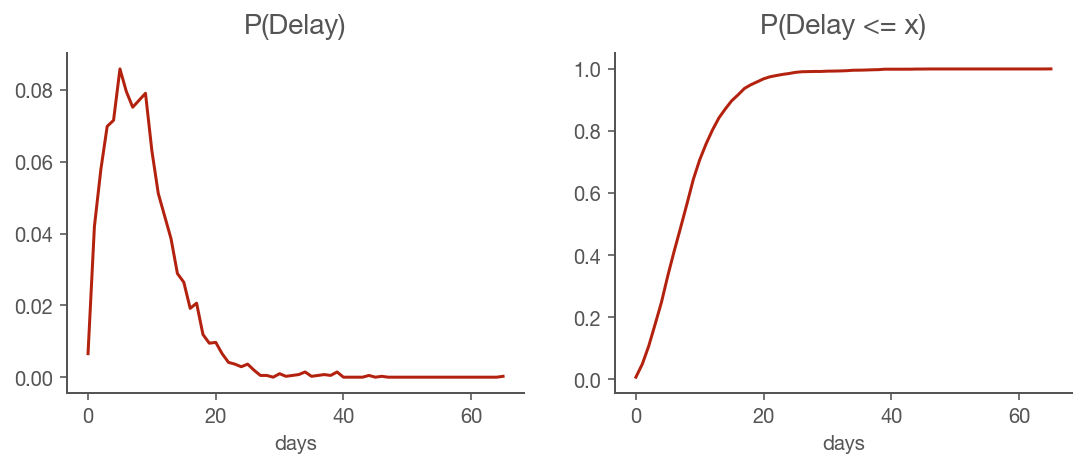

In [955]:
# Calculate the delta in days between onset and confirmation
delay = (patients.Confirmed - patients.Onset).dt.days

# Convert samples to an empirical distribution
p_delay = delay.value_counts().sort_index()
new_range = np.arange(0, p_delay.index.max()+1)
p_delay = p_delay.reindex(new_range, fill_value=0)
p_delay /= p_delay.sum()

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(9,3))
p_delay.plot(title='P(Delay)', ax=axes[0])
p_delay.cumsum().plot(title='P(Delay <= x)', ax=axes[1])
for ax in axes:
    ax.set_xlabel('days')

In [956]:
pdelayDF = pd.DataFrame(p_delay, columns=['pdelay'])
pdelayDF.index.name = 'index'
pdelayDF

,pdelay
index,
0,0.006547
1,0.041950
2,0.057711
3,0.069835
4,0.071532
...,...
61,0.000000
62,0.000000
63,0.000000


In [957]:
pdelayDF.to_csv('data/pdelay.csv')

## A Single Country

#### Select country Data

In [1007]:
country = 'Italy'
confirmed = countries.xs(country).cases
confirmed['2020-03-19']

4207.0

### Translate Confirmation Dates to Onset Dates

Our goal is to translate positive test counts to the dates where they likely occured. Since we have the distribution, we can distribute case counts back in time according to that distribution. To accomplish this, we reverse the case time series, and convolve it using the distribution of delay from onset to confirmation. Then we reverse the series again to obtain the onset curve. Note that this means the data will be 'right censored' which means there are onset cases that have yet to be reported so it looks as if the count has gone down.

In [1008]:
# Maps pd.Series to pd.Series indexed by dates_considered
def confirmed_to_onset(confirmed, p_delay):
    assert not confirmed.isna().any()
    # First, we take a convolution with pdelay to distribute the cases confirmed at a certain time
    # to the appropriate date of onset 
    convolved = np.convolve(confirmed[::-1].values, p_delay)
    # Since covolution increases the size of the array, we clip the data in order to to fit the index
    return pd.Series(np.flip(convolved[:dates_considered.size]), index=dates_considered, name='Onset')

In [1009]:
onset = confirmed_to_onset(confirmed, p_delay)

In [1010]:
onset

2020-02-15    154.250000
2020-02-16    188.673375
2020-02-17    226.310863
2020-02-18    272.241028
2020-02-19    321.920466
                 ...    
2020-05-03    319.538070
2020-05-04    223.195441
2020-05-05    136.424345
2020-05-06     67.613240
2020-05-07      9.453928
Freq: D, Name: Onset, Length: 83, dtype: float64

In [1011]:
# Adding pd.DataFrame layer to the result of confirmed_to_onset
def process(country, data):
    onset = confirmed_to_onset(data['cases'], p_delay)
    newindex = pd.MultiIndex.from_tuples([(country,date) for date in dates_considered],names=['country','date'])
    return pd.DataFrame(data=onset.values,index=newindex,columns=['Onset'])

countriesOnset = pd.concat([process(country,data) for country, data in countries.groupby('country')])

In [1012]:
countriesOnset

Onset
country        date                   
Austria        2020-02-15     5.621969
               2020-02-16     6.259457
               2020-02-17     7.192532
               2020-02-18     8.328807
               2020-02-19    10.227934
...                                ...
United_Kingdom 2020-05-03  1195.444229
               2020-05-04   883.596993
               2020-05-05   569.362512
               2020-05-06   289.395005
               2020-05-07    40.663676

[2656 rows x 1 columns]

In [1013]:
countriesOnset.to_csv('data/onset.csv')

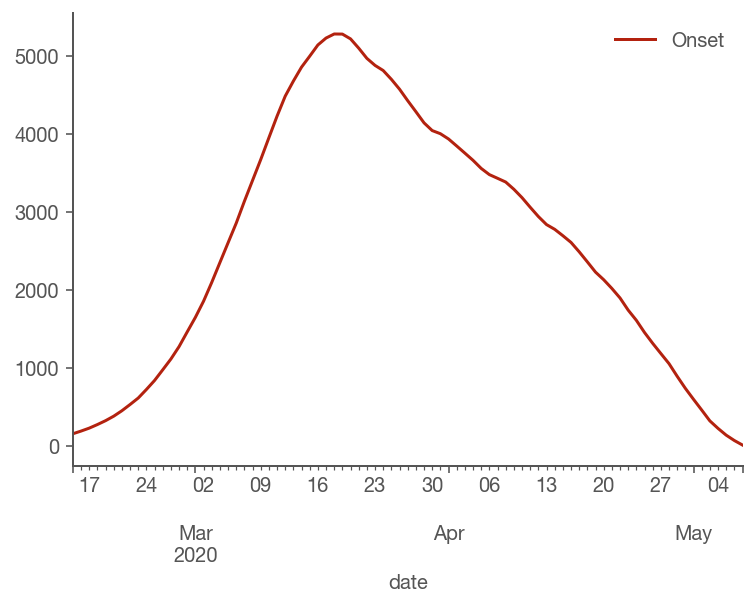

In [1014]:
countriesOnset.loc[country].plot()

### Adjust for Right-Censoring

Since we distributed observed cases into the past to recreate the onset curve, we now have a right-censored time series. We can correct for that by asking what % of people have a delay less than or equal to the time between the day in question and the current day.

For example, 5 days ago, there might have been 100 cases onset. Over the course of the next 5 days some portion of those cases will be reported. This portion is equal to the cumulative distribution function of our delay distribution. If we know that portion is say, 60%, then our current count of onset on that day represents 60% of the total. This implies that the total is 166% higher. We apply this correction to get an idea of what actual onset cases are likely, thus removing the right censoring.

In [1026]:
def adjust_onset_for_right_censorship(onset, p_delay):
    cumulative_p_delay = p_delay.cumsum()
    # Calculate the additional ones needed so shapes match
    ones_needed = np.max([len(onset) - len(cumulative_p_delay),0])
    padding_shape = (0, ones_needed)
    # Add ones and flip back
    cumulative_p_delay = np.pad(
        cumulative_p_delay,
        padding_shape,
        constant_values=1)
    cumulative_p_delay = np.flip(cumulative_p_delay[:onset.size])
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_p_delay
    
    return adjusted, cumulative_p_delay

In [1027]:
adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)

Take a look at all three series: confirmed, onset and onset adjusted for right censoring.

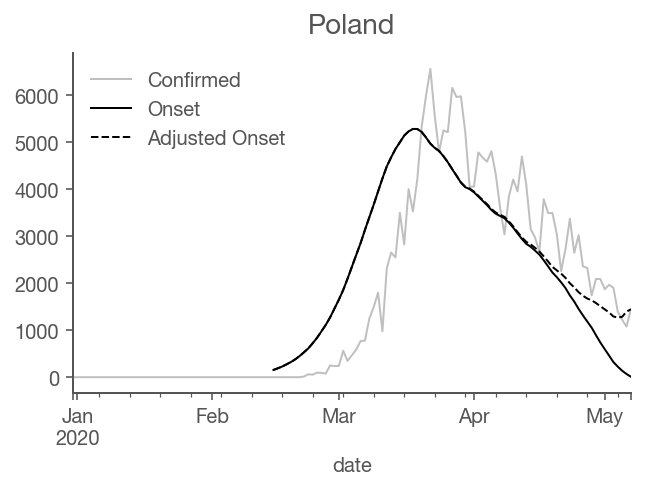

In [1028]:
fig, ax = plt.subplots(figsize=(5,3))

confirmed.plot(
    ax=ax,
    label='Confirmed',
    title=country,
    c='k',
    alpha=.25,
    lw=1)

onset.plot(
    ax=ax,
    label='Onset',
    c='k',
    lw=1)

adjusted.plot(
    ax=ax,
    label='Adjusted Onset',
    c='k',
    linestyle='--',
    lw=1)

ax.legend();

Let's have the model run on days where we have enough data ~last 50 or so

### Sample the Posterior with PyMC3

We assume a poisson likelihood function and feed it what we believe is the onset curve based on reported data. We model this onset curve based on the same math in the previous notebook:

$$ I^\prime = Ie^{\gamma(R_t-1)} $$

We define $\theta = \gamma(R_t-1)$ and model $ I^\prime = Ie^{\theta} $ where $\theta$ observes a random walk. We let $\gamma$ vary independently based on known parameters for the serial interval. Therefore, we can recover $R_t$ easily by $R_t = \frac{\theta}{\gamma}+1$

The only tricky part is understanding that we're feeding in _onset_ cases to the likelihood. So $\mu$ of the poisson is the positive, non-zero, expected onset cases we think we'd see today.

We calculate this by figuring out how many cases we'd expect there to be yesterday total when adjusted for bias and plugging it into the first equation above. We then have to re-bias this number back down to get the expected amount of onset cases observed that day.

In [1029]:
class MCMCModel(object):
    
    def __init__(self, region, onset, cumulative_p_delay, window=50):
        
        # Just for identification purposes
        self.region = region
        
        # For the model, we'll only look at the last N
        self.onset = onset.iloc[-window:]
        self.cumulative_p_delay = cumulative_p_delay[-window:]
        
        # Where we store the results
        self.trace = None
        self.trace_index = self.onset.index[1:]

    def run(self, chains=1, tune=3000, draws=1000, target_accept=.95):

        with pm.Model() as model:

            # Random walk magnitude
            step_size = pm.HalfNormal('step_size', sigma=.03)

            # Theta random walk
            theta_raw_init = pm.Normal('theta_raw_init', 0.1, 0.1)
            theta_raw_steps = pm.Laplace('theta_raw_steps', mu=0, b=step_size, shape=len(self.onset)-2)
            theta_raw = tt.concatenate([[theta_raw_init], theta_raw_steps])
            theta = pm.Deterministic('theta', theta_raw.cumsum())

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta/gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            expected_today = inferred_yesterday * (self.cumulative_p_delay[1:]) * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(
                chains=chains,
                tune=tune,
                draws=draws,
                target_accept=target_accept)
            
            return self
    
    def run_gp(self):
        with pm.Model() as model:
            gp_shape = len(self.onset) - 1

            length_scale = pm.Gamma("length_scale", alpha=3, beta=.4)

            eta = .05
            cov_func = eta**2 * pm.gp.cov.ExpQuad(1, length_scale)

            gp = pm.gp.Latent(mean_func=pm.gp.mean.Constant(c=0), 
                              cov_func=cov_func)

            # Place a GP prior over the function f.
            theta = gp.prior("theta", X=np.arange(gp_shape)[:, None])

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta / gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(chains=1, tune=1000, draws=1000, target_accept=.8)
        return self

### Run Pymc3 Model

In [1030]:
def df_from_model(model):
    
    r_t = model.trace['r_t']
    mean = np.mean(r_t, axis=0)
    median = np.median(r_t, axis=0)
    hpd_90 = pm.stats.hpd(r_t, credible_interval=.9)
    hpd_50 = pm.stats.hpd(r_t, credible_interval=.5)
    
    idx = pd.MultiIndex.from_product([
            [model.region],
            model.trace_index
        ], names=['region', 'date'])
        
    df = pd.DataFrame(data=np.c_[mean, median, hpd_90, hpd_50], index=idx,
                 columns=['mean', 'median', 'lower_90', 'upper_90', 'lower_50','upper_50'])
    return df

def create_and_run_model(name, country):
    confirmed = country.cases
    onset = confirmed_to_onset(confirmed, p_delay)
    _ , cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)
    return MCMCModel(name, onset, cumulative_p_delay, window=1000).run(tune=1000)

In [1031]:
quick_countries = ['Poland'] #, 'Italy', 'Austria', 'France', 'Germany', 'Spain', 'Netherlands', 'Belgium']
models = {}

In [ ]:
for country, grp in countries.groupby('country'):
    
    # TODO: fixup the data or automate skipping of countries with broken data
#     if country in ['Lithuania', 'Portugal']:
#         continue
    
    if quick_countries and not country in quick_countries:
        continue
    
    print(country)
    
    if country in models:
        print(f'Skipping {country}, already in cache')
        continue
    
    models[country] = create_and_run_model(country, grp.droplevel(0))

Poland


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences:  79%|███████▊  | 1573/2000 [02:25<00:38, 11.08it/s]

### Handle Divergences

In [640]:
# Check to see if there were divergences
n_diverging = lambda x: x.trace['diverging'].nonzero()[0].size
divergences = pd.Series([n_diverging(m) for m in models.values()], index=models.keys())
has_divergences = divergences.gt(0)

print('Diverging countries:')
display(divergences[has_divergences])

# Rerun countries with divergences
for country, n_divergences in divergences[has_divergences].items():
    models[country].run()

Diverging countries:


Series([], dtype: int64)

## Compile Results

In [641]:
results = None

for country, model in models.items():

    df = df_from_model(model)

    if results is None:
        results = df
    else:
        results = pd.concat([results, df], axis=0)

In [642]:
results.loc['Poland']

,mean,median,lower_90,upper_90,lower_50,upper_50
date,,,,,,
2020-02-16,1.369298,1.323526,1.076241,1.733224,1.153387,1.392813
2020-02-17,1.370994,1.326710,1.051176,1.691919,1.180365,1.422835
2020-02-18,1.369799,1.331644,1.060487,1.684051,1.138389,1.378150
2020-02-19,1.363980,1.321958,1.048584,1.670174,1.134402,1.364437
2020-02-20,1.361404,1.319696,1.051042,1.675361,1.117367,1.349072
...,...,...,...,...,...,...
2020-05-02,0.445898,0.524769,-0.024749,0.932153,0.420026,0.765731
2020-05-03,0.443912,0.521128,-0.046609,0.958408,0.417146,0.775645
2020-05-04,0.444637,0.518231,-0.043597,0.974120,0.374080,0.736714


### Render to CSV
Uncomment if you'd like

In [643]:
results.to_csv('data/rt_mcmc.csv')

### Render Charts

In [644]:
def plot_rt(name, result, ax, c=(.3,.3,.3,1), ci=(0,0,0,.05)):
    ax.set_ylim(0.0, 2)
    ax.set_title(name)
    ax.plot(result['median'],
            marker='o',
            markersize=4,
            markerfacecolor='w',
            lw=1,
            c=c,
            markevery=2)
    ax.fill_between(
        result.index,
        result['lower_90'].values,
        result['upper_90'].values,
        color=ci,
        lw=0)
    ax.axhline(1.0, linestyle=':', lw=1)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

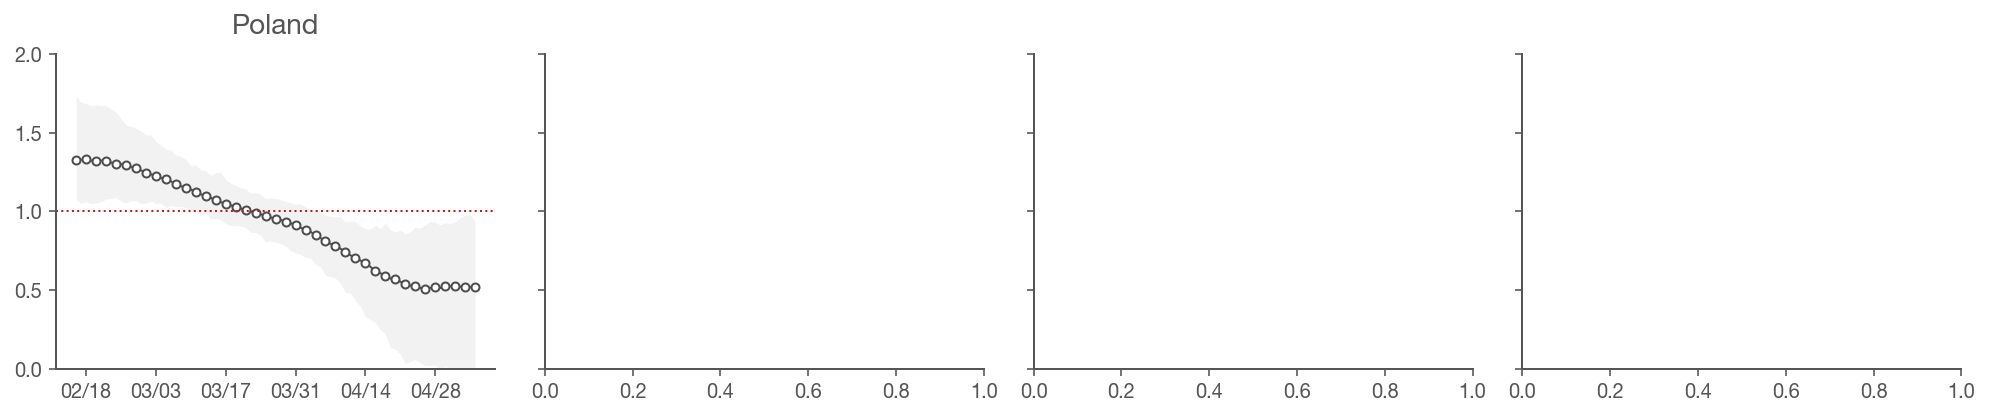

In [645]:
# Laplace walk
ncols = 4
nrows = int(np.ceil(results.index.levels[0].shape[0] / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(14, nrows*3),
    sharey='row')

for ax, (country, result) in zip(axes.flat, results.groupby('region')):
    plot_rt(country, result.droplevel(0), ax)

fig.tight_layout()
fig.set_facecolor('w')

In [ ]:
# Gaussain walk
ncols = 4
nrows = int(np.ceil(results.index.levels[0].shape[0] / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(14, nrows*3),
    sharey='row')

for ax, (country, result) in zip(axes.flat, results.groupby('region')):
    plot_rt(country, result.droplevel(0), ax)

fig.tight_layout()
fig.set_facecolor('w')

In [ ]:
# url = 'https://raw.githubusercontent.com/jasonong/List-of-US-countries/master/countries.csv'
# abbrev = pd.read_csv(url, index_col=['country'], squeeze=True)

# jhu_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
# jhu = pd.read_csv(jhu_url)

# jhu = jhu.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'])
# jhu = jhu.set_index('Province_country')
# jhu.index = jhu.index.rename('region')
# jhu = jhu.drop([
#     'American Samoa',
#     'Guam',
#     'Northern Mariana Islands',
#     'Puerto Rico',
#     'Virgin Islands',
#     'Diamond Princess',
#     'Grand Princess'])

# jhu.index = pd.Index(jhu.index.to_series().replace(abbrev).values, name='region')
# jhu.columns = pd.to_datetime(jhu.columns)
# jhu = jhu.groupby('region').sum()
# jhu = jhu.stack().sort_index()

# country = 'VT'
# ax = jhu.xs(country).diff().plot(label='JHU', color='k', legend=True, title=country)
# # jhu.xs('AK').diff().rolling(7).mean().plot(ax=ax)
# countries.xs(country).positive.diff().plot(ax=ax, figsize=(6,4), linestyle=':', label='Covidtracking', legend=True)
# ax.set_xlim(pd.Timestamp('2020-03-01'),None)

In [ ]:
# url = 'https://raw.githubusercontent.com/epiforecasts/covid-regional/3ad63ea1acceb797f0628a8037fc206342d267e7/united-countries/regional-summary/rt.csv'

# epf = pd.read_csv(url, parse_dates=['date'])
# epf.region = epf.region.replace(abbrev)
# epf = epf.set_index(['region', 'date']).sort_index()
# epf = epf.drop(['Guam', 'Puerto Rico'])

# epf_lookup = {}
# for idx, grp in epf.groupby('region'):

#     epf_lookup[idx]=grp
#     epf_grp = epf_lookup[country]
    
#     plot_rt(country, result.droplevel(0), ax)
#     plot_rt(country, epf_grp.droplevel(0), ax, c=(1,0,0,1))